In [50]:
'TODO: Fit with PEP8 style'
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import string
import re
import unidecode
from bs4 import BeautifulSoup
from nltk import tokenize, download
from nltk.sentiment import SentimentIntensityAnalyzer

In [51]:
# Preprocess data
def prepocess_data(rest_info, michelin_keys):
    """"
    A function that reads in the restaurant and review .json data, and returns a dataframe to be preprocessed for analysis,
    with some manipulations

    Input: two file names: rest_info for restaurant information, and michelin_keys for the michelin dictionary
    Output: df, a combined dataframe of restaurant and review data
    """

    # Read in restaurant data
    restaurants = pd.read_json(rest_info).T

    # Read in the review data
    # Define dataframe for reviews
    reviews = pd.DataFrame()

    # Loop through all review .jsons
    for letter in string.ascii_lowercase + '0':
        path = "{}/reviews/{}.json".format(os.getcwd(), letter)
        with open(path, "r") as json_file:
            alias_to_reviews = json.loads(json_file.read())

            # For each alias, get reviews
            for alias in alias_to_reviews.keys():

                # Flatten structure into dataframe, track alias for easy groupby/merge with restaurants
                review = pd.json_normalize(alias_to_reviews[alias], sep="_")
                review['alias'] = alias
                
                # Stitch into final dataframe
                reviews = pd.concat([reviews, review], ignore_index=True)

    # Get michelin keys
    mich_dict = pd.Series(json.load(open(michelin_keys)))

    # Append michelin information to restaurant dataframe
    restaurants['michelin'] = restaurants['alias'].isin(mich_dict)

    # Merge restaurants with review data
    # Extract restaurant information
    rest_data = restaurants[['alias', 'name', 'categories', 'price', 'coordinates', 'michelin']]

    # Merge dataframes for analysis
    df = pd.merge(reviews, rest_data, on='alias')

    # Trim for efficiency
    df.drop(['comment_language'], axis=1, inplace=True)

    # Flatten the categories to extract the titles for analysis
    df.loc[:, 'categories'] = df['categories'].apply(lambda x: [item['title'] for item in x])

    # Rename columns for ease
    df.columns = ['user_photo_count', 'user_review_count', 'elite_year', 'review_date','rating','review',
                  'alias','name','categories','price','location', 'michelin']

    # Return dataframe for analyis
    return df

In [52]:
# Test function
test = prepocess_data('restaurants.json', 'michelin_alias.json')
test

,user_photo_count,user_review_count,elite_year,review_date,rating,review,alias,name,categories,price,location,michelin
0,190.0,1421.0,NaN,8/6/2023,3.0,Overall the food is pretty good but portions c...,ani-ramen-house-new-york,Ani Ramen House,"[Noodles, Ramen]",NaN,"{'latitude': 40.7124742, 'longitude': -74.0156...",False
1,580.0,148.0,2023.0,6/8/2023,4.0,We&#39;ve been to ani ramen in Montclair New J...,ani-ramen-house-new-york,Ani Ramen House,"[Noodles, Ramen]",NaN,"{'latitude': 40.7124742, 'longitude': -74.0156...",False
2,531.0,186.0,2023.0,5/24/2023,4.0,The real deal Japanese rice. Crispy tofu was t...,ani-ramen-house-new-york,Ani Ramen House,"[Noodles, Ramen]",NaN,"{'latitude': 40.7124742, 'longitude': -74.0156...",False
3,770.0,213.0,2023.0,7/18/2023,3.0,This is located within Brookfield place. You c...,ani-ramen-house-new-york,Ani Ramen House,"[Noodles, Ramen]",NaN,"{'latitude': 40.7124742, 'longitude': -74.0156...",False
4,692.0,185.0,2023.0,11/12/2022,1.0,I have been wanting to try Ani Ramen for the l...,ani-ramen-house-new-york,Ani Ramen House,"[Noodles, Ramen]",NaN,"{'latitude': 40.7124742, 'longitude': -74.0156...",False
...,...,...,...,...,...,...,...,...,...,...,...,...
331688,641.0,361.0,2023.0,3/20/2018,3.0,I honestly think between 161-170th in the area...,167-street-nonnas-pizza-new-york,167 Street Nonna's Pizza,[Pizza],$,"{'latitude': 40.83443, 'longitude': -73.91685}",False
331689,30.0,11.0,NaN,2/15/2015,4.0,Awesome pizza for the area. Prices can be a l...,167-street-nonnas-pizza-new-york,167 Street Nonna's Pizza,[Pizza],$,"{'latitude': 40.83443, 'longitude': -73.91685}",False
331690,1.0,4.0,NaN,2/19/2015,1.0,"I called to order. When I gave my address, whi...",167-street-nonnas-pizza-new-york,167 Street Nonna's Pizza,[Pizza],$,"{'latitude': 40.83443, 'longitude': -73.91685}",False
331691,23.0,20.0,NaN,2/19/2015,1.0,I called this place to place a delivery order....,167-street-nonnas-pizza-new-york,167 Street Nonna's Pizza,[Pizza],$,"{'latitude': 40.83443, 'longitude': -73.91685}",False


In [53]:
save_copy = test.copy()

In [54]:
# Function to preprocess the data for analysis
def preprocess_reviews(df):
    """
    A function that cleans the dataframe text for reviews
    TODO: MAke this a series, it returns a dataframe for now
    TODO: remove warning
    """
    # Drop duplicate reviews (use copy to avoid Pandas warning)
    df = df[df['review'].duplicated() == False].copy()

    # Drop no reviews
    df = df[~df['review'].isna()]

    # Remove HTML tags from text using Beautiful Soup
    # Why a library over regular expressions? Better edge case handling
    df.loc[:, 'review'] = df['review'].apply(lambda x: unidecode.unidecode(BeautifulSoup(x, 'html.parser').get_text(separator=' '))) 
    # The warning just means maybe not all contain HTML tags, it's fine. Unidecode to remove non-English chars

    # Remove odd characters, rest seem plausible
    df.loc[:, 'review'] = df['review'].apply(lambda x: re.sub(r'[{}*\r\\\^#`|]', '', x)) # Hashtags don't work with VADER

    # Remove extra spaces
    df.loc[:, 'review'] = df['review'].apply(lambda x: re.sub(r'\s+', ' ', x))

    # Return cleaned dataframe
    return df

In [55]:
test2 = preprocess_reviews(save_copy)
test2

/var/folders/_q/gmdf_7c54956tq7fvnbprqw00000gn/T/ipykernel_73932/3322762232.py:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df.loc[:, 'review'] = df['review'].apply(lambda x: unidecode.unidecode(BeautifulSoup(x, 'html.parser').get_text(separator=' ')))


,user_photo_count,user_review_count,elite_year,review_date,rating,review,alias,name,categories,price,location,michelin
0,190.0,1421.0,NaN,8/6/2023,3.0,Overall the food is pretty good but portions c...,ani-ramen-house-new-york,Ani Ramen House,"[Noodles, Ramen]",NaN,"{'latitude': 40.7124742, 'longitude': -74.0156...",False
1,580.0,148.0,2023.0,6/8/2023,4.0,We've been to ani ramen in Montclair New Jerse...,ani-ramen-house-new-york,Ani Ramen House,"[Noodles, Ramen]",NaN,"{'latitude': 40.7124742, 'longitude': -74.0156...",False
2,531.0,186.0,2023.0,5/24/2023,4.0,The real deal Japanese rice. Crispy tofu was t...,ani-ramen-house-new-york,Ani Ramen House,"[Noodles, Ramen]",NaN,"{'latitude': 40.7124742, 'longitude': -74.0156...",False
3,770.0,213.0,2023.0,7/18/2023,3.0,This is located within Brookfield place. You c...,ani-ramen-house-new-york,Ani Ramen House,"[Noodles, Ramen]",NaN,"{'latitude': 40.7124742, 'longitude': -74.0156...",False
4,692.0,185.0,2023.0,11/12/2022,1.0,I have been wanting to try Ani Ramen for the l...,ani-ramen-house-new-york,Ani Ramen House,"[Noodles, Ramen]",NaN,"{'latitude': 40.7124742, 'longitude': -74.0156...",False
...,...,...,...,...,...,...,...,...,...,...,...,...
331688,641.0,361.0,2023.0,3/20/2018,3.0,I honestly think between 161-170th in the area...,167-street-nonnas-pizza-new-york,167 Street Nonna's Pizza,[Pizza],$,"{'latitude': 40.83443, 'longitude': -73.91685}",False
331689,30.0,11.0,NaN,2/15/2015,4.0,Awesome pizza for the area. Prices can be a li...,167-street-nonnas-pizza-new-york,167 Street Nonna's Pizza,[Pizza],$,"{'latitude': 40.83443, 'longitude': -73.91685}",False
331690,1.0,4.0,NaN,2/19/2015,1.0,"I called to order. When I gave my address, whi...",167-street-nonnas-pizza-new-york,167 Street Nonna's Pizza,[Pizza],$,"{'latitude': 40.83443, 'longitude': -73.91685}",False
331691,23.0,20.0,NaN,2/19/2015,1.0,I called this place to place a delivery order....,167-street-nonnas-pizza-new-york,167 Street Nonna's Pizza,[Pizza],$,"{'latitude': 40.83443, 'longitude': -73.91685}",False


In [92]:
# Now return what is necessary for the VADER
def run_vader(reviews, downloaded = False, test_method = True):
    """
    Make comments here
    Returns two series for the polarity
    TODO: remove warning
    """

    # If user needs dependencies, download them to run VADER
    if downloaded:
        download('punkt')
        download('vader_lexicon')

    # Get a list for tracking sentiment of each review
    overall_sent = []

    # Get sentiment object
    sid = SentimentIntensityAnalyzer()

    # Get list of reviews
    review_list = list(reviews)

    # Tokenize each review on sentence level, get VADER output for each sentence and take the mean
    for rev in review_list:
        review = tokenize.sent_tokenize(rev)
        rev_sent = []

        # Now for each sentence, get the polarity
        for i in review:
            rev_sent.append(sid.polarity_scores(i)['compound'])
        
        # Stitch mean to list for final output
        overall_sent.append(np.array(rev_sent).mean())

    # If the user wants to compare methodologies, calculate and return both methods
    if test_method:
        rev_sent = []

        # For each sentence, apply VADER to the entire sentence
        for sentence in review_list:
            rev_sent.append(sid.polarity_scores(sentence)['compound'])

        # Return both
        return overall_sent, rev_sent
    
    # Else return just the mean methodology
    return [overall_sent]

In [59]:
tester = run_vader(test2['review'])
tester

/var/folders/_q/gmdf_7c54956tq7fvnbprqw00000gn/T/ipykernel_73932/3520782960.py:33: RuntimeWarning: Mean of empty slice.
  overall_sent.append(np.array(rev_sent).mean())


([0.30395999999999995,
  0.300825,
  0.22037142857142858,
  -0.019190000000000002,
  0.03939285714285715,
  0.54322,
  0.09106666666666667,
  0.30003,
  0.43970000000000004,
  0.14614999999999997,
  0.15945,
  -0.1468,
  0.022799999999999997,
  0.029280000000000007,
  0.18296923076923077,
  0.11712727272727273,
  0.27115,
  -0.07558333333333334,
  0.21026190476190476,
  -0.06319090909090909,
  -0.19389,
  -0.290625,
  0.169,
  0.41078333333333333,
  0.3499333333333334,
  0.18288571428571426,
  0.0794,
  0.16752,
  0.07208,
  0.167375,
  0.0593,
  0.08137857142857143,
  0.0890875,
  0.24630999999999997,
  0.059311538461538464,
  0.43574285714285715,
  0.3667666666666667,
  0.01986666666666666,
  0.69355,
  0.2547461538461539,
  0.1535586206896552,
  0.02404615384615385,
  0.09006666666666667,
  0.16808333333333333,
  0.34141666666666665,
  0.1164142857142857,
  0.34816666666666674,
  0.18767142857142857,
  0.27295,
  0.3151333333333333,
  0.32208333333333333,
  0.08015333333333333,
  0.

In [157]:
def analyze_vader(df, sentiment, test_method = True):
    """
    A function that will stitch VADER to the dataframe, and spit out the metrics and visuals
    """
    # Add sentiment column
    df['polarity'] = sentiment[0]

    # Test correlation of polarity score and rating
    corr_polarity = df['polarity'].corr(df['rating'], method='spearman') # this is good (Spearman for rank data, working with ratings)
    print('The Spearman Rank Correlation between review sentiment and rating (averaging method) is : ' + str(corr_polarity))

    # Perform classification for positive and negative reviews
    df['polarity_class'] = np.nan
    df.loc[df['polarity'] > 0.025, 'polarity_class']  = 'Positive'
    df.loc[df['polarity'] < -0.025, 'polarity_class']  = 'Negative'
    df.loc[((df['polarity'] > -0.025) & (df['polarity'] < 0.025)), 'polarity_class'] = 'Neutral'

    # Aggregate rating distribution for plotting
    # For averaging method
    count_class = df.groupby('polarity_class')['rating'].value_counts(normalize=True).to_frame()
    count_class.sort_index(inplace=True)

    # If the user would like to test the non-averaging method...
    if test_method:
        # Test correlation of polarity score and rating
        df['polarity_total'] = sentiment[1]
        corr_polarity_non = df['polarity_total'].corr(df['rating'], method='spearman') 
        print('The Spearman Rank Correlation between review sentiment and rating (non-averaging method) is : ' + str(corr_polarity_non))

        # Perform classification for postiive and negative scores
        df['polarity_tot_class'] = np.nan
        df.loc[df['polarity_total'] > 0.025, 'polarity_tot_class']  = 'Positive'
        df.loc[df['polarity_total'] < -0.025, 'polarity_tot_class']  = 'Negative'
        df.loc[((df['polarity_total'] > -0.025) & (df['polarity_total'] < 0.025)), 'polarity_tot_class'] = 'Neutral'

        # Plot the distributions (we get better spread)
        fig, ax = plt.subplots(1, 2, sharey=True, tight_layout=True)

        ax[0].hist(df['polarity'], bins = 10, color = 'blue')
        ax[0].set_title('Averaging Method')
        ax[0].set_xlabel('Polarity')
        ax[1].hist(df['polarity_total'], bins = 10, color = 'orange')
        ax[1].set_title('Non-Averaging Method')
        ax[1].set_xlabel('Polarity')
        plt.show()

        # See boxplots of polarity on the data
        fig, ax = plt.subplots(figsize=(8, 8), nrows=1, ncols=2, sharey=True, tight_layout=True)

        # Get the data by rating
        rating_data_avg = [df[df['rating'] == x]['polarity'] for x in range(1, int(df['rating'].max() + 1))]
        rating_data_nonavg = [df[df['rating'] == x]['polarity_total'] for x in range(1, int(df['rating'].max() + 1))]

        # We want a boxplot of polarity
        ax[0].boxplot(rating_data_avg)
        ax[1].boxplot(rating_data_nonavg)

        # Subset polarity by ratings
        ax[0].set_xticks([x + 1 for x in range(len(rating_data_avg))], labels=[str(x+1) for x in range(len(rating_data_avg))])
        ax[0].set_xlabel('Rating')
        ax[0].set_ylabel('Polarity')
        ax[0].set_title('Averaging Method')

        ax[1].set_xticks([x + 1 for x in range(len(rating_data_nonavg))], labels=[str(x+1) for x in range(len(rating_data_nonavg))])
        ax[1].set_xlabel('Rating')
        ax[1].set_title('Non-Averaging Method')
        plt.show()


        # Plot rating distribution by sentiment class
        # Get rating distribution by class for the non-averaging method
        count_class_non = df.groupby('polarity_tot_class')['rating'].value_counts(normalize=True).to_frame()
        count_class_non.sort_index(inplace=True)

        # Show bar chart (1 by 1x2)
        fig, axes = plt.subplots(1, 2, figsize=(15, 8))

        # Get the x, y axes
        y_avg = [str(x) for x in count_class.index]
        percentage_avg = count_class['rating']

        y_non_avg = [str(x) for x in count_class_non.index]
        percentage_non_avg = count_class_non['rating']

        # Generate bar chart
        hbars_avg = axes[0].barh(y_avg, percentage_avg, align='center', color='green', label=percentage_avg)
        hbars_non = axes[1].barh(y_non_avg, percentage_non_avg, align='center', color='red', label=percentage_non_avg)

        axes[0].set_yticks(y_avg)
        axes[0].invert_yaxis() # Invert to show top first
        axes[0].bar_label(hbars_avg, labels=[round(x, 2) for x in percentage_avg])
        axes[0].set_xlabel('Percentage')
        axes[0].set_ylabel('Review Class')
        axes[0].set_title('Averaging Method')

        axes[1].set_yticks(y_non_avg)
        axes[1].invert_yaxis() # Invert to show top first
        axes[1].bar_label(hbars_non, labels=[round(x, 2) for x in percentage_non_avg])
        axes[1].set_xlabel('Percentage')
        axes[1].set_ylabel('Review Class')
        axes[1].set_title('Non-Averaging Method')

        fig.tight_layout(rect=[0, 0, 2, 1]) # Adjust padding
        plt.show()

        # Trim class for final dataframe
        df.drop(['polarity_total', 'polarity_tot_class'], axis=1, inplace=True)
        
    else:
        # Plot only the averaging method
        fig, ax = plt.subplots()
        ax.hist(df['polarity'], bins = 10, color = 'blue')
        ax.set_title('Averaging Method')
        ax.set_xlabel('Polarity')
        plt.show()

        # See boxplots of polarity on the data
        fig, ax = plt.subplots(figsize=(8, 8))

        # Get the data by rating
        rating_data_avg = [df[df['rating'] == x]['polarity'] for x in range(1, int(df['rating'].max() + 1))]

        # We want a boxplot of polarity
        ax.boxplot(rating_data_avg)

        # Subset polarity by ratings
        ax.set_xticks([x + 1 for x in range(len(rating_data_avg))], labels=[str(x+1) for x in range(len(rating_data_avg))])
        ax.set_xlabel('Rating')
        ax.set_ylabel('Polarity')
        ax.set_title('Averaging Method')
        plt.show()

        # Plot rating distribution by sentiment class
        # Show bar chart (1 by 1x2)
        fig, axes = plt.subplots(figsize=(10, 6))

        # Get the x, y axes
        y_avg = [str(x) for x in count_class.index]
        percentage_avg = count_class['rating']

        # Generate bar chart
        hbars_avg = axes.barh(y_avg, percentage_avg, align='center', color='green', label=percentage_avg)

        axes.set_yticks(y_avg)
        axes.invert_yaxis() # Invert to show top first
        axes.bar_label(hbars_avg, labels=[round(x, 2) for x in percentage_avg])
        axes.set_xlabel('Percentage')
        axes.set_ylabel('Review Class')
        axes.set_title('Averaging Method')
        plt.show()

    # Return dataframe, and list of plots
    return df


The Spearman Rank Correlation between review sentiment and rating (averaging method) is : 0.6341896550093563


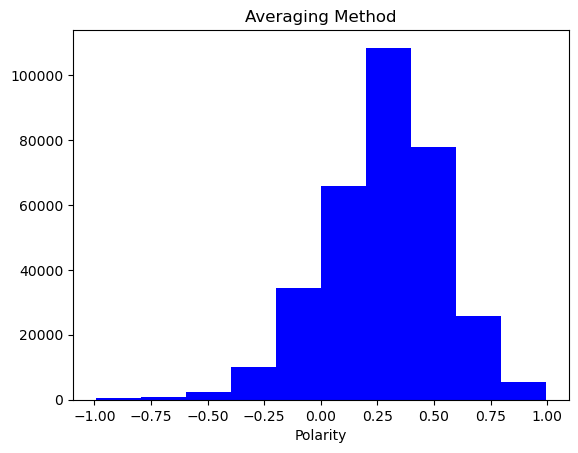

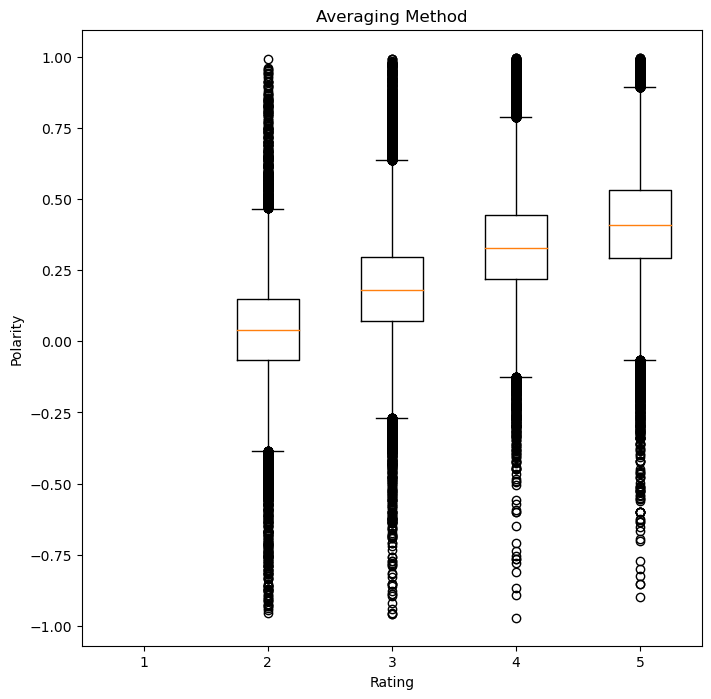

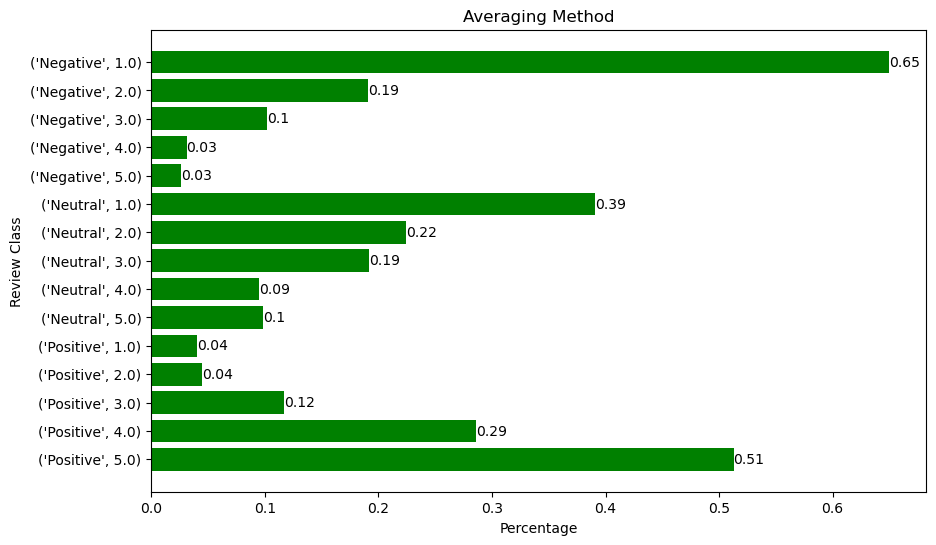

In [160]:
testing = analyze_vader(test2, tester, False)

In [161]:
testing.head()

,user_photo_count,user_review_count,elite_year,review_date,rating,review,alias,name,categories,price,location,michelin,polarity,polarity_class
0,190.0,1421.0,NaN,8/6/2023,3.0,Overall the food is pretty good but portions c...,ani-ramen-house-new-york,Ani Ramen House,"[Noodles, Ramen]",NaN,"{'latitude': 40.7124742, 'longitude': -74.0156...",False,0.303960,Positive
1,580.0,148.0,2023.0,6/8/2023,4.0,We've been to ani ramen in Montclair New Jerse...,ani-ramen-house-new-york,Ani Ramen House,"[Noodles, Ramen]",NaN,"{'latitude': 40.7124742, 'longitude': -74.0156...",False,0.300825,Positive
2,531.0,186.0,2023.0,5/24/2023,4.0,The real deal Japanese rice. Crispy tofu was t...,ani-ramen-house-new-york,Ani Ramen House,"[Noodles, Ramen]",NaN,"{'latitude': 40.7124742, 'longitude': -74.0156...",False,0.220371,Positive
3,770.0,213.0,2023.0,7/18/2023,3.0,This is located within Brookfield place. You c...,ani-ramen-house-new-york,Ani Ramen House,"[Noodles, Ramen]",NaN,"{'latitude': 40.7124742, 'longitude': -74.0156...",False,-0.019190,Neutral
4,692.0,185.0,2023.0,11/12/2022,1.0,I have been wanting to try Ani Ramen for the l...,ani-ramen-house-new-york,Ani Ramen House,"[Noodles, Ramen]",NaN,"{'latitude': 40.7124742, 'longitude': -74.0156...",False,0.039393,Positive
